In [1]:
%reload_ext autoreload
%autoreload 2
from alpharaw.ms_data_base import ms_reader_provider
from alpharaw import register_all_readers
from dia_aspire_rescore.io import read_diann2
import pandas as pd
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
from dia_aspire_rescore.psm.matcher import DIAPeptideSpectrumMatcher
from alphabase.peptide.fragment import flatten_fragments
import numpy as np
import os

output_dir = "../../tests/test_data/test_matcher"
os.makedirs(output_dir, exist_ok=True)


register_all_readers()

/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alpharaw/raw_access/pysciexwifffilereader.py:44: UserWarning: Dotnet-based dependencies could not be loaded. Sciex support is disabled.
  warnings.warn(
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alpharaw/raw_access/pythermorawfilereader.py:35: UserWarning: Dotnet-based dependencies could not be loaded. Thermo support is disabled.
  warnings.warn(


In [2]:
psm_df_original = read_diann2("../../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet")
# decreasing rt order
psm_df_sorted = psm_df_original.sort_values(by="nAA", ascending=True)
psm_df_sorted = psm_df_sorted[psm_df_sorted['fdr1_search1'] < 0.01].reset_index(drop=True)

spec_dict = {}
peak_dict = {}

for run in psm_df_original['raw_name'].unique():
    hdf_reader = ms_reader_provider.get_reader("hdf5")
    hdf_reader.load_raw(f"../output/{run}.mzML.hdf5")
    spec_dict[run] = hdf_reader.spectrum_df
    peak_dict[run] = hdf_reader.peak_df
    
matcher = DIAPeptideSpectrumMatcher(n_neighbors=0)
psm_df_sorted_in = psm_df_sorted[0:1].copy()
psm_df, fragment_mz_df, matched_intensity_df, matched_mz_err_df = matcher.match_ms2_multi_raw(
    psm_df_sorted_in,
    {'20200317_QE_HFX2_LC3_DIA_RA957_R01': '../output/20200317_QE_HFX2_LC3_DIA_RA957_R01.mzML.hdf5',
     '20200317_QE_HFX2_LC3_DIA_RA957_R02': '../output/20200317_QE_HFX2_LC3_DIA_RA957_R02.mzML.hdf5'},
    'hdf5',
)

psm_df, flat_frag_df = flatten_fragments(
    precursor_df=psm_df,
    fragment_mz_df=fragment_mz_df,
    fragment_intensity_df=matched_intensity_df
)

def plot_spectrum(spec_dict, peak_dict, psm_df, psm_idx, flat_frag_df, ):
    id = psm_df.iloc[psm_idx]['raw_name'] + '_' + str(psm_df.iloc[psm_idx]['spec_idx'])
    spec_id = psm_df.iloc[psm_idx]['spec_idx']
    print(f'raw_name: {psm_df.iloc[psm_idx]["raw_name"]}')
    print(f'seq: {psm_df.iloc[psm_idx]["sequence"]}')
    print(f'mods: {psm_df.iloc[psm_idx]["mods"]}')
    print(f'mod_sites: {psm_df.iloc[psm_idx]["mod_sites"]}')
    print(f'spec_idx: {psm_df.iloc[psm_idx]["spec_idx"]}')
    print(f'precursor_mz: {psm_df.iloc[psm_idx]["precursor_mz"]}')
    print(f'charge: {psm_df.iloc[psm_idx]["charge"]}')
    print(f'sequence: {psm_df.iloc[psm_idx]["sequence"]}')
    print(f'rt: {psm_df.iloc[psm_idx]["rt"]}')
    print(f'rt_start: {psm_df.iloc[psm_idx]["rt_start"]}')
    print(f'rt_stop: {psm_df.iloc[psm_idx]["rt_stop"]}')
    print(f'frag_start_idx: {psm_df.iloc[psm_idx]["frag_start_idx"]}')
    print(f'frag_stop_idx: {psm_df.iloc[psm_idx]["frag_stop_idx"]}')
    peak_df = peak_dict[psm_df.iloc[psm_idx]['raw_name']]
    spec_df = spec_dict[psm_df.iloc[psm_idx]['raw_name']]
    peak_start = spec_df.loc[spec_id, 'peak_start_idx']
    peak_stop = spec_df.loc[spec_id, 'peak_stop_idx']
    print(f'peak_start: {peak_start}')
    print(f'peak_stop: {peak_stop}')
    flat_frag_start_idx = psm_df.iloc[psm_idx]['flat_frag_start_idx']
    flat_frag_stop_idx = psm_df.iloc[psm_idx]['flat_frag_stop_idx']
    flat_frags = flat_frag_df.iloc[flat_frag_start_idx:flat_frag_stop_idx]
    #frag_mz_df = 
    
    peak_mz = peak_df['mz'][peak_start:peak_stop]
    peak_intensity = peak_df['intensity'][peak_start:peak_stop]
    spectrum = sus.MsmsSpectrum(
        identifier=id,
        precursor_mz=psm_df.iloc[psm_idx]['precursor_mz'],  
        precursor_charge=psm_df.iloc[psm_idx]['charge'],
        mz=peak_mz,
        intensity=peak_intensity,
    )
    spectrum.annotate_proforma(
        psm_df.iloc[psm_idx]['sequence'], # TODO: peptidoform
        fragment_tol_mass=20,
        fragment_tol_mode='ppm',
        ion_types="by",
        max_ion_charge=2,
    )
    fig, ax = plt.subplots(figsize=(12, 6))
    sup.spectrum(spectrum, grid=False, ax=ax)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.show()
    
    return flat_frags
    

/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alphabase/psm_reader/psm_reader.py:342: UserWarning: Unknown modifications: {'Q(UniMod:1)'}. Precursors with unknown modifications will be removed.
  warnings.warn(
100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


raw_name: 20200317_QE_HFX2_LC3_DIA_RA957_R01
seq: LPGPGASL
mods: 
mod_sites: 
spec_idx: 54755
precursor_mz: 711.4035664385599
charge: 1
sequence: LPGPGASL
rt: 73.93505096435547
rt_start: 73.81211853027344
rt_stop: 74.1202163696289
frag_start_idx: 0
frag_stop_idx: 7
peak_start: 77533536
peak_stop: 77535847


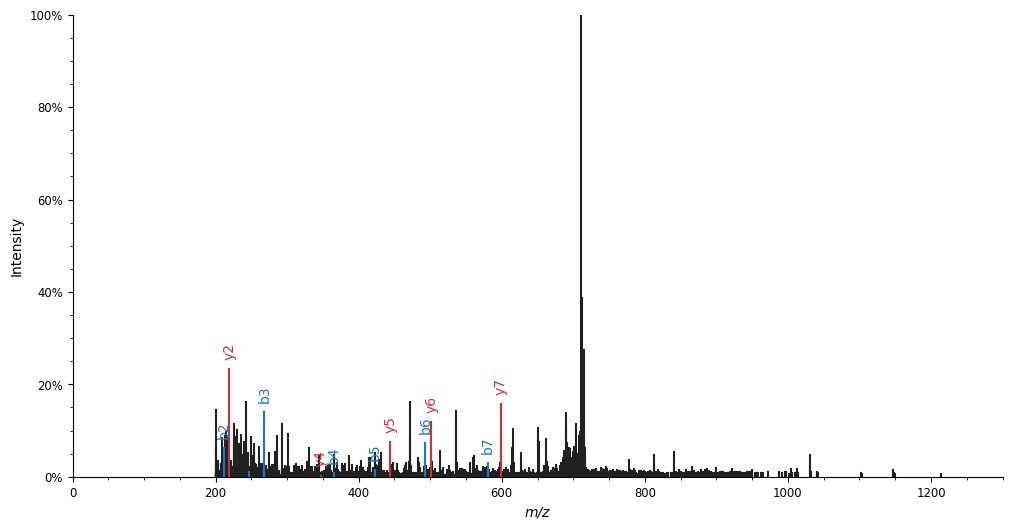

In [3]:
frags = plot_spectrum(spec_dict, peak_dict, psm_df, 0, flat_frag_df)

In [4]:
output_path = os.path.join(output_dir, "frags_0.tsv")
frags.to_csv(output_path, sep='\t', index=False)
frags

,mz,intensity,type,loss_type,charge,number,position
0,114.091339,0.000000,98,0,1,1,0
1,598.319519,494901.531250,121,0,1,7,0
2,211.144104,194970.406250,98,0,1,2,1
3,501.266724,374790.312500,121,0,1,6,1
4,268.165558,440298.562500,98,0,1,3,2
5,444.245270,236016.218750,121,0,1,5,2
6,365.218323,22997.832031,98,0,1,4,3
7,347.192505,5882.197266,121,0,1,4,3
8,422.239807,42980.621094,98,0,1,5,4
9,290.171051,0.000000,121,0,1,3,4


In [5]:
fragment_mz_df, matched_intensity_df, matched_mz_err_df

(         b_z1  b_z2        y_z1  y_z2
 0  114.091339   0.0  598.319519   0.0
 1  211.144104   0.0  501.266724   0.0
 2  268.165558   0.0  444.245270   0.0
 3  365.218323   0.0  347.192505   0.0
 4  422.239807   0.0  290.171051   0.0
 5  493.276917   0.0  219.133926   0.0
 6  580.308960   0.0  132.101898   0.0,
             b_z1  b_z2           y_z1  y_z2
 0       0.000000   0.0  494901.531250   0.0
 1  194970.406250   0.0  374790.312500   0.0
 2  440298.562500   0.0  236016.218750   0.0
 3   22997.832031   0.0    5882.197266   0.0
 4   42980.621094   0.0       0.000000   0.0
 5  233700.390625   0.0  737157.750000   0.0
 6   93787.937500   0.0       0.000000   0.0,
        b_z1  b_z2      y_z1  y_z2
 0       inf   inf  0.006409   inf
 1  0.001190   inf  0.003387   inf
 2  0.001465   inf  0.002106   inf
 3  0.003357   inf  0.000244   inf
 4  0.002228   inf       inf   inf
 5  0.004028   inf  0.001236   inf
 6  0.007874   inf       inf   inf)

---

In [6]:
psm_df_original = read_diann2("../../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet")
# decreasing rt order
psm_df_sorted = psm_df_original.sort_values(by="nAA", ascending=True)
psm_df_sorted = psm_df_sorted[psm_df_sorted['fdr1_search1'] < 0.01].reset_index(drop=True)

spec_dict = {}
peak_dict = {}

for run in psm_df_original['raw_name'].unique():
    hdf_reader = ms_reader_provider.get_reader("hdf5")
    hdf_reader.load_raw(f"../output/{run}.mzML.hdf5")
    spec_dict[run] = hdf_reader.spectrum_df
    peak_dict[run] = hdf_reader.peak_df
    
matcher = DIAPeptideSpectrumMatcher(n_neighbors=0)
psm_df_sorted_in = psm_df_sorted[1:2].copy()
psm_df, fragment_mz_df, matched_intensity_df, matched_mz_err_df = matcher.match_ms2_multi_raw(
    psm_df_sorted_in,
    {'20200317_QE_HFX2_LC3_DIA_RA957_R01': '../output/20200317_QE_HFX2_LC3_DIA_RA957_R01.mzML.hdf5',
     '20200317_QE_HFX2_LC3_DIA_RA957_R02': '../output/20200317_QE_HFX2_LC3_DIA_RA957_R02.mzML.hdf5'},
    'hdf5',
)

psm_df, flat_frag_df = flatten_fragments(
    precursor_df=psm_df,
    fragment_mz_df=fragment_mz_df,
    fragment_intensity_df=matched_intensity_df
)

def plot_spectrum(spec_dict, peak_dict, psm_df, psm_idx, flat_frag_df, ):
    id = psm_df.iloc[psm_idx]['raw_name'] + '_' + str(psm_df.iloc[psm_idx]['spec_idx'])
    spec_id = psm_df.iloc[psm_idx]['spec_idx']
    print(f'raw_name: {psm_df.iloc[psm_idx]["raw_name"]}')
    print(f'seq: {psm_df.iloc[psm_idx]["sequence"]}')
    print(f'mods: {psm_df.iloc[psm_idx]["mods"]}')
    print(f'mod_sites: {psm_df.iloc[psm_idx]["mod_sites"]}')
    print(f'spec_idx: {psm_df.iloc[psm_idx]["spec_idx"]}')
    print(f'precursor_mz: {psm_df.iloc[psm_idx]["precursor_mz"]}')
    print(f'charge: {psm_df.iloc[psm_idx]["charge"]}')
    print(f'sequence: {psm_df.iloc[psm_idx]["sequence"]}')
    print(f'rt: {psm_df.iloc[psm_idx]["rt"]}')
    print(f'rt_start: {psm_df.iloc[psm_idx]["rt_start"]}')
    print(f'rt_stop: {psm_df.iloc[psm_idx]["rt_stop"]}')
    print(f'frag_start_idx: {psm_df.iloc[psm_idx]["frag_start_idx"]}')
    print(f'frag_stop_idx: {psm_df.iloc[psm_idx]["frag_stop_idx"]}')
    peak_df = peak_dict[psm_df.iloc[psm_idx]['raw_name']]
    spec_df = spec_dict[psm_df.iloc[psm_idx]['raw_name']]
    peak_start = spec_df.loc[spec_id, 'peak_start_idx']
    peak_stop = spec_df.loc[spec_id, 'peak_stop_idx']
    print(f'peak_start: {peak_start}')
    print(f'peak_stop: {peak_stop}')
    flat_frag_start_idx = psm_df.iloc[psm_idx]['flat_frag_start_idx']
    flat_frag_stop_idx = psm_df.iloc[psm_idx]['flat_frag_stop_idx']
    flat_frags = flat_frag_df.iloc[flat_frag_start_idx:flat_frag_stop_idx]
    #frag_mz_df = 
    
    peak_mz = peak_df['mz'][peak_start:peak_stop]
    peak_intensity = peak_df['intensity'][peak_start:peak_stop]
    spectrum = sus.MsmsSpectrum(
        identifier=id,
        precursor_mz=psm_df.iloc[psm_idx]['precursor_mz'],  
        precursor_charge=psm_df.iloc[psm_idx]['charge'],
        mz=peak_mz,
        intensity=peak_intensity,
    )
    spectrum.annotate_proforma(
        psm_df.iloc[psm_idx]['sequence'], # TODO: peptidoform
        fragment_tol_mass=20,
        fragment_tol_mode='ppm',
        ion_types="by",
        max_ion_charge=2,
    )
    fig, ax = plt.subplots(figsize=(12, 6))
    sup.spectrum(spectrum, grid=False, ax=ax)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.show()
    
    return flat_frags
    

/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alphabase/psm_reader/psm_reader.py:342: UserWarning: Unknown modifications: {'Q(UniMod:1)'}. Precursors with unknown modifications will be removed.
  warnings.warn(
100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


raw_name: 20200317_QE_HFX2_LC3_DIA_RA957_R01
seq: LPGPAESL
mods: 
mod_sites: 
spec_idx: 55953
precursor_mz: 783.42469580662
charge: 1
sequence: LPGPAESL
rt: 75.56661224365234
rt_start: 75.29045867919922
rt_stop: 75.8424072265625
frag_start_idx: 0
frag_stop_idx: 7
peak_start: 79988810
peak_stop: 79991619


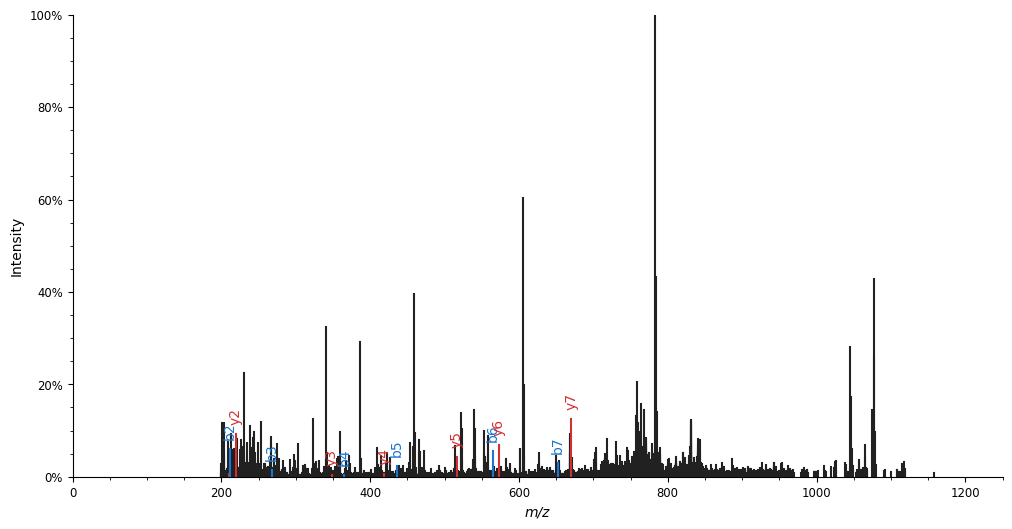

In [7]:
frags = plot_spectrum(spec_dict, peak_dict, psm_df, 0, flat_frag_df)

In [8]:
output_path = os.path.join(output_dir, "frags_1.tsv")
frags.to_csv(output_path, sep='\t', index=False)
frags

,mz,intensity,type,loss_type,charge,number,position
0,114.091339,0.000000,98,0,1,1,0
1,670.340637,376321.718750,121,0,1,7,0
2,211.144104,180740.359375,98,0,1,2,1
3,573.287842,203957.078125,121,0,1,6,1
4,268.165558,43121.746094,98,0,1,3,2
5,516.266418,127932.140625,121,0,1,5,2
6,365.218323,10784.710938,98,0,1,4,3
7,419.213654,15643.356445,121,0,1,4,3
8,436.255432,67585.703125,98,0,1,5,4
9,348.176514,9559.760742,121,0,1,3,4


In [10]:
fragment_mz_df, matched_intensity_df, matched_mz_err_df

(         b_z1  b_z2        y_z1  y_z2
 0  114.091339   0.0  670.340637   0.0
 1  211.144104   0.0  573.287842   0.0
 2  268.165558   0.0  516.266418   0.0
 3  365.218323   0.0  419.213654   0.0
 4  436.255432   0.0  348.176514   0.0
 5  565.298035   0.0  219.133926   0.0
 6  652.330078   0.0  132.101898   0.0,
             b_z1  b_z2           y_z1  y_z2
 0       0.000000   0.0  376321.718750   0.0
 1  180740.359375   0.0  203957.078125   0.0
 2   43121.746094   0.0  127932.140625   0.0
 3   10784.710938   0.0   15643.356445   0.0
 4   67585.703125   0.0    9559.760742   0.0
 5  167944.218750   0.0  277635.812500   0.0
 6   86476.593750   0.0       0.000000   0.0,
        b_z1  b_z2      y_z1  y_z2
 0       inf   inf  0.005432   inf
 1  0.001160   inf  0.004395   inf
 2  0.000549   inf  0.005676   inf
 3  0.002747   inf  0.007141   inf
 4  0.003540   inf  0.002258   inf
 5  0.007080   inf  0.001266   inf
 6  0.006348   inf       inf   inf)

---

In [11]:
hdf5_reader = ms_reader_provider.get_reader("hdf5")
hdf5_reader.load_raw("../output/20200317_QE_HFX2_LC3_DIA_RA957_R01.mzML.hdf5")

In [12]:
spec_df = hdf5_reader.spectrum_df
peak_df = hdf5_reader.peak_df

In [13]:
# build test data; extract spec whose rt >= 73.515889 and <= 75.483047
spec_df_mock = spec_df[(spec_df['rt'] >= 73.515889) & (spec_df['rt'] < 75.8)].reset_index(drop=True)
spec_df_mock

,isolation_lower_mz,isolation_upper_mz,ms_level,peak_start_idx,peak_stop_idx,precursor_charge,precursor_mz,rt,spec_idx
0,-1.0,-1.0,1,76872568,76875728,0,-1.0,73.515889,54418
1,350.0,387.0,2,76875728,76877681,0,368.5,73.520109,54419
2,386.0,416.0,2,76877681,76879496,0,401.0,73.521230,54420
3,415.0,439.0,2,76879496,76881299,0,427.0,73.522350,54421
4,438.0,462.0,2,76881299,76883182,0,450.0,73.523473,54422
...,...,...,...,...,...,...,...,...,...
1704,386.0,416.0,2,80323539,80325298,0,401.0,75.794832,56122
1705,415.0,439.0,2,80325298,80327172,0,427.0,75.795954,56123
1706,438.0,462.0,2,80327172,80328537,0,450.0,75.797075,56124
1707,461.0,483.0,2,80328537,80329453,0,472.0,75.798196,56125


In [14]:
start_idx = int(spec_df_mock.iloc[0]['peak_start_idx'])
stop_idx = int(spec_df_mock.iloc[-1]['peak_stop_idx'])
start_spec_idx = int(spec_df_mock.iloc[0]['spec_idx'])
start_idx, stop_idx, start_spec_idx

(76872568, 80330629, 54418)

In [15]:
spec_df_mock['peak_start_idx'] = spec_df_mock['peak_start_idx'] - start_idx
spec_df_mock['peak_stop_idx'] = spec_df_mock['peak_stop_idx'] - start_idx
spec_df_mock['spec_idx'] = spec_df_mock['spec_idx'] - start_spec_idx
spec_df_mock

,isolation_lower_mz,isolation_upper_mz,ms_level,peak_start_idx,peak_stop_idx,precursor_charge,precursor_mz,rt,spec_idx
0,-1.0,-1.0,1,0,3160,0,-1.0,73.515889,0
1,350.0,387.0,2,3160,5113,0,368.5,73.520109,1
2,386.0,416.0,2,5113,6928,0,401.0,73.521230,2
3,415.0,439.0,2,6928,8731,0,427.0,73.522350,3
4,438.0,462.0,2,8731,10614,0,450.0,73.523473,4
...,...,...,...,...,...,...,...,...,...
1704,386.0,416.0,2,3450971,3452730,0,401.0,75.794832,1704
1705,415.0,439.0,2,3452730,3454604,0,427.0,75.795954,1705
1706,438.0,462.0,2,3454604,3455969,0,450.0,75.797075,1706
1707,461.0,483.0,2,3455969,3456885,0,472.0,75.798196,1707


In [16]:
peak_df_mock = peak_df[start_idx:stop_idx].reset_index(drop=True)
peak_df_mock

,intensity,mz
0,9.593477e+05,300.180420
1,4.821504e+05,300.917236
2,1.871879e+06,301.081818
3,4.156535e+05,301.486084
4,1.515681e+06,302.160034
...,...,...
3458056,8.587202e+04,898.487183
3458057,1.302924e+05,902.479858
3458058,1.208239e+05,903.475464
3458059,7.010294e+04,905.522461


In [17]:
# Create new hdf5 reader and save the mock data

hdf5_writer = ms_reader_provider.get_reader("hdf5")
hdf5_writer.spectrum_df = spec_df_mock.copy()
hdf5_writer.peak_df = peak_df_mock.copy()

output_path = os.path.join(output_dir, "test_data.hdf5")
hdf5_writer.save_hdf(output_path)
print(f"Saved test data to {output_path}")
print(f"Number of spectra: {len(spec_df_mock)}")
print(f"Number of peaks: {len(peak_df_mock)}")

Saved test data to ../tests/test_data/test_matcher/test_data.hdf5
Number of spectra: 1709
Number of peaks: 3458061


---

In [18]:
psm_df = pd.read_csv(os.path.join(output_dir, "psm_df.tsv"), sep="\t")
for col in ["mods", "mod_sites"]:
    if col not in psm_df.columns:
        psm_df[col] = ""
    else:
        psm_df[col] = psm_df[col].fillna("").astype(str)


psm_df, fragment_mz_df, matched_intensity_df, matched_mz_err_df = matcher.match_ms2_multi_raw(
    psm_df,
    {'20200317_QE_HFX2_LC3_DIA_RA957_R01': os.path.join(output_dir, "test_data.hdf5")},
    'hdf5',
)

100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Testing PSM 0: LPGPGASL


100%|██████████| 1/1 [00:00<00:00, 27.96it/s]


raw_name: 20200317_QE_HFX2_LC3_DIA_RA957_R01
seq: LPGPGASL
mods: 
mod_sites: 
spec_idx: 337
precursor_mz: 711.4035664385599
charge: 1
sequence: LPGPGASL
rt: 73.93505
rt_start: 73.81212
rt_stop: 74.12022
frag_start_idx: 0
frag_stop_idx: 7
peak_start: 660968
peak_stop: 663279


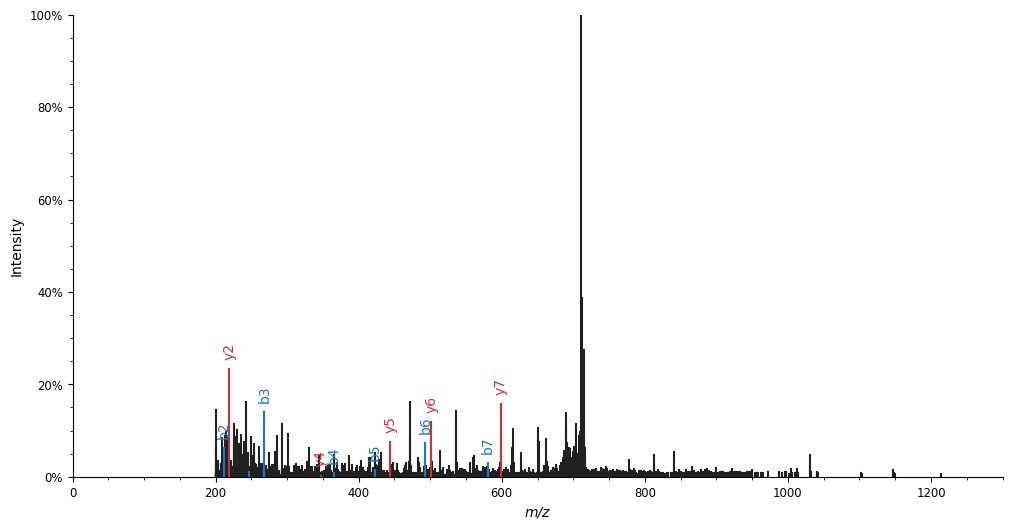


Fragments for PSM 0:
            mz      intensity  type  number  position
0   114.091339       0.000000    98       1         0
1   598.319519  494901.531250   121       7         0
2   211.144104  194970.406250    98       2         1
3   501.266724  374790.312500   121       6         1
4   268.165558  440298.562500    98       3         2
5   444.245270  236016.218750   121       5         2
6   365.218323   22997.832031    98       4         3
7   347.192505    5882.197266   121       4         3
8   422.239807   42980.621094    98       5         4
9   290.171051       0.000000   121       3         4
10  493.276917  233700.390625    98       6         5
11  219.133926  737157.750000   121       2         5
12  580.308960   93787.937500    98       7         6
13  132.101898       0.000000   121       1         6


In [19]:
# Test with mock data - PSM 0 (LPGPGASL)
print("=" * 60)
print("Testing PSM 0: LPGPGASL")
print("=" * 60)

# Load mock data
hdf5_reader_mock = ms_reader_provider.get_reader("hdf5")
hdf5_reader_mock.load_raw(os.path.join(output_dir, "test_data.hdf5"))
spec_dict_mock = {"20200317_QE_HFX2_LC3_DIA_RA957_R01": hdf5_reader_mock.spectrum_df}
peak_dict_mock = {"20200317_QE_HFX2_LC3_DIA_RA957_R01": hdf5_reader_mock.peak_df}

# Load PSM data
psm_df_test = pd.read_csv(os.path.join(output_dir, "psm_df.tsv"), sep="\t")
for col in ["mods", "mod_sites"]:
    if col not in psm_df_test.columns:
        psm_df_test[col] = ""
    else:
        psm_df_test[col] = psm_df_test[col].fillna("").astype(str)

# Process PSM 0
matcher = DIAPeptideSpectrumMatcher(n_neighbors=0)
psm_df_0 = psm_df_test.iloc[0:1].copy()
psm_df_matched_0, fragment_mz_df_0, matched_intensity_df_0, matched_mz_err_df_0 = matcher.match_ms2_multi_raw(
    psm_df_0,
    {"20200317_QE_HFX2_LC3_DIA_RA957_R01": os.path.join(output_dir, "test_data.hdf5")},
    "hdf5",
)

psm_df_matched_0, flat_frag_df_0 = flatten_fragments(
    precursor_df=psm_df_matched_0,
    fragment_mz_df=fragment_mz_df_0,
    fragment_intensity_df=matched_intensity_df_0,
)

# Plot and get fragments
frags_0 = plot_spectrum(spec_dict_mock, peak_dict_mock, psm_df_matched_0, 0, flat_frag_df_0)
print("\nFragments for PSM 0:")
print(frags_0[['mz', 'intensity', 'type', 'number', 'position']])


Testing PSM 1: LPGPAESL


100%|██████████| 1/1 [00:00<00:00, 25.20it/s]

raw_name: 20200317_QE_HFX2_LC3_DIA_RA957_R01
seq: LPGPAESL
mods: 
mod_sites: 
spec_idx: 1535
precursor_mz: 783.42469580662
charge: 1
sequence: LPGPAESL
rt: 75.56661
rt_start: 75.29046
rt_stop: 75.84241
frag_start_idx: 0
frag_stop_idx: 7
peak_start: 3116242
peak_stop: 3119051


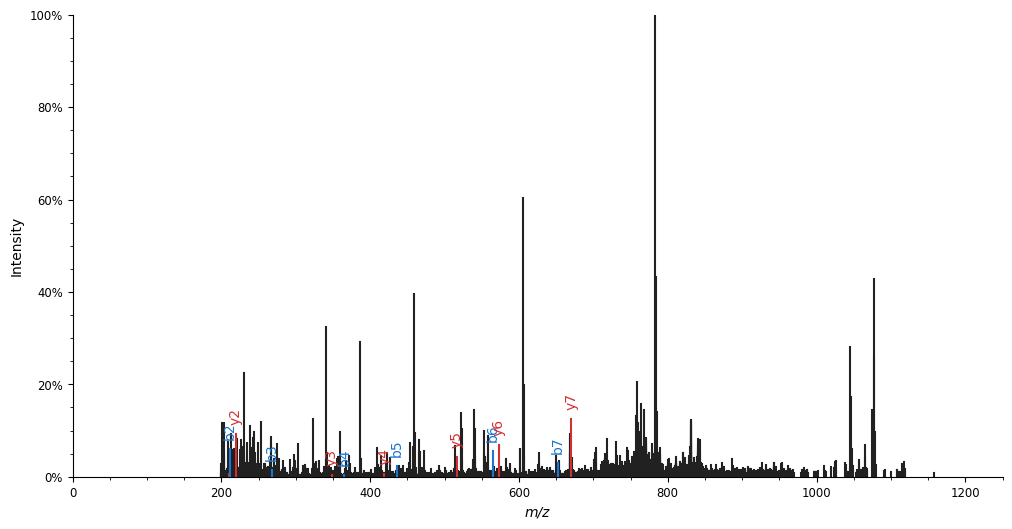


Fragments for PSM 1:
            mz      intensity  type  number  position
0   114.091339       0.000000    98       1         0
1   670.340637  376321.718750   121       7         0
2   211.144104  180740.359375    98       2         1
3   573.287842  203957.078125   121       6         1
4   268.165558   43121.746094    98       3         2
5   516.266418  127932.140625   121       5         2
6   365.218323   10784.710938    98       4         3
7   419.213654   15643.356445   121       4         3
8   436.255432   67585.703125    98       5         4
9   348.176514    9559.760742   121       3         4
10  565.298035  167944.218750    98       6         5
11  219.133926  277635.812500   121       2         5
12  652.330078   86476.593750    98       7         6
13  132.101898       0.000000   121       1         6


In [20]:
# Test with mock data - PSM 1 (LPGPAESL)
print("=" * 60)
print("Testing PSM 1: LPGPAESL")
print("=" * 60)

# Process PSM 1
matcher = DIAPeptideSpectrumMatcher(n_neighbors=0)
psm_df_1 = psm_df_test.iloc[1:2].copy()
psm_df_matched_1, fragment_mz_df_1, matched_intensity_df_1, matched_mz_err_df_1 = matcher.match_ms2_multi_raw(
    psm_df_1,
    {"20200317_QE_HFX2_LC3_DIA_RA957_R01": os.path.join(output_dir, "test_data.hdf5")},
    "hdf5",
)

psm_df_matched_1, flat_frag_df_1 = flatten_fragments(
    precursor_df=psm_df_matched_1,
    fragment_mz_df=fragment_mz_df_1,
    fragment_intensity_df=matched_intensity_df_1,
)

# Plot and get fragments
frags_1 = plot_spectrum(spec_dict_mock, peak_dict_mock, psm_df_matched_1, 0, flat_frag_df_1)
print("\nFragments for PSM 1:")
print(frags_1[['mz', 'intensity', 'type', 'number', 'position']])


In [21]:
psm_df

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs,frag_start_idx,frag_stop_idx,spec_idx
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPGASL,1,73.93505,73.81212,74.12022,0.0,1/sp|Q9Y6J0|CABIN_HUMAN,1/sp|Q9Y6J0|CABIN_HUMAN,NaN,...,0.0,,,8,0.617759,711.403566,0.0,0,7,337
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPAESL,1,75.56661,75.29046,75.84241,0.0,1/sp|Q86WR7|PRSR2_HUMAN,1/sp|Q86WR7|PRSR2_HUMAN,NaN,...,0.0,,,8,0.631391,783.424696,0.0,7,14,1535
